# Network Traffic Classification

## [CICIDS2017 Intrusion Detection Evaluation Dataset](https://www.kaggle.com/cicdataset/cicids2017)

CICIDS2017 dataset contains benign and the most up-to-date common attacks, which resembles the true real-world data (PCAPs). It also includes the results of the network traffic analysis using CICFlowMeter with labeled flows based on the time stamp, source, and destination IPs, source and destination ports, protocols and attack.

The data capturing period started at 9 a.m., Monday, July 3, 2017, and ended at 5 p.m. on Friday, July 7, 2017, for a total of 5 days. 
Monday is the normal day and only includes benign traffic. The implemented attacks include Brute Force FTP, Brute Force SSH, DoS, Heartbleed, Web Attack, Infiltration, Botnet and DDoS. They have been executed both morning and afternoon on Tuesday, Wednesday, Thursday and Friday.

The intent of this analysis is to train and test a classification method to identify if a capture network traffic register is benign or malign considering the Friday DDoS dataset. For more information about DDoS atacks see [here](https://www.cloudflare.com/learning/ddos/what-is-a-ddos-attack/).

## Initial exploration of the dataset

This analysis start importing the tools required for ploting, preprocessing, data processing and direcories reading.

In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_digits
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

There are 8 files in this dataset but we will use only one: `Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv`.

In [2]:
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
data/Monday-WorkingHours.pcap_ISCX.csv
data/Friday-WorkingHours-Morning.pcap_ISCX.csv
data/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
data/Tuesday-WorkingHours.pcap_ISCX.csv
data/Wednesday-workingHours.pcap_ISCX.csv
data/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv


The three methods below were built with the intention to facilitate the generation of distribution, correlation, and scatter plots visualizations. They provide analysis over each field and correlation combination possible.  
I am not responsible for the creation of these methods, the original work was made by [this](https://www.kaggle.com/kerneler) very helpful Kaggle user. 

In [3]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 20]] # For displaying purposes, pick columns that have between 1 and 20 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [4]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    #filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix', fontsize=15)
    plt.show()

In [5]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

### Friday DDoS dataset analysis

In [6]:
rows = None # numbers of lines to read. None = all
ddos = pd.read_csv('data/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', delimiter=',', nrows = rows)
ddos.dataframeName = 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'
nRow, nCol = ddos.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 225745 rows and 79 columns


Peaking at the rows we can see there is a `Label` field we can use to build a classification method.

In [7]:
ddos.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Count the unique values from all columns.

In [8]:
a = ddos.nunique()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(a.sort_values(ascending=True))

 Fwd Avg Packets/Bulk                1
 Bwd Avg Bytes/Bulk                  1
 Bwd Avg Packets/Bulk                1
Bwd Avg Bulk Rate                    1
 CWE Flag Count                      1
 Fwd Avg Bulk Rate                   1
Fwd Avg Bytes/Bulk                   1
 Bwd PSH Flags                       1
 Fwd URG Flags                       1
 Bwd URG Flags                       1
 RST Flag Count                      2
FIN Flag Count                       2
 ACK Flag Count                      2
 URG Flag Count                      2
Fwd PSH Flags                        2
 ECE Flag Count                      2
 SYN Flag Count                      2
 PSH Flag Count                      2
 Label                               2
 Down/Up Ratio                       8
 min_seg_size_forward                8
 Min Packet Length                 109
 Fwd Packet Length Min             151
 act_data_pkt_fwd                  234
Subflow Fwd Packets                297
 Total Fwd Packets       

Doesn't make sense get unique values from columns that have counts an gauges so we need to get the distribution graphs only from columns that have from 2 to 20 unique values.

<ipython-input-3-3767a2c45b2f>:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nGraphRow, nGraphPerRow, i + 1)


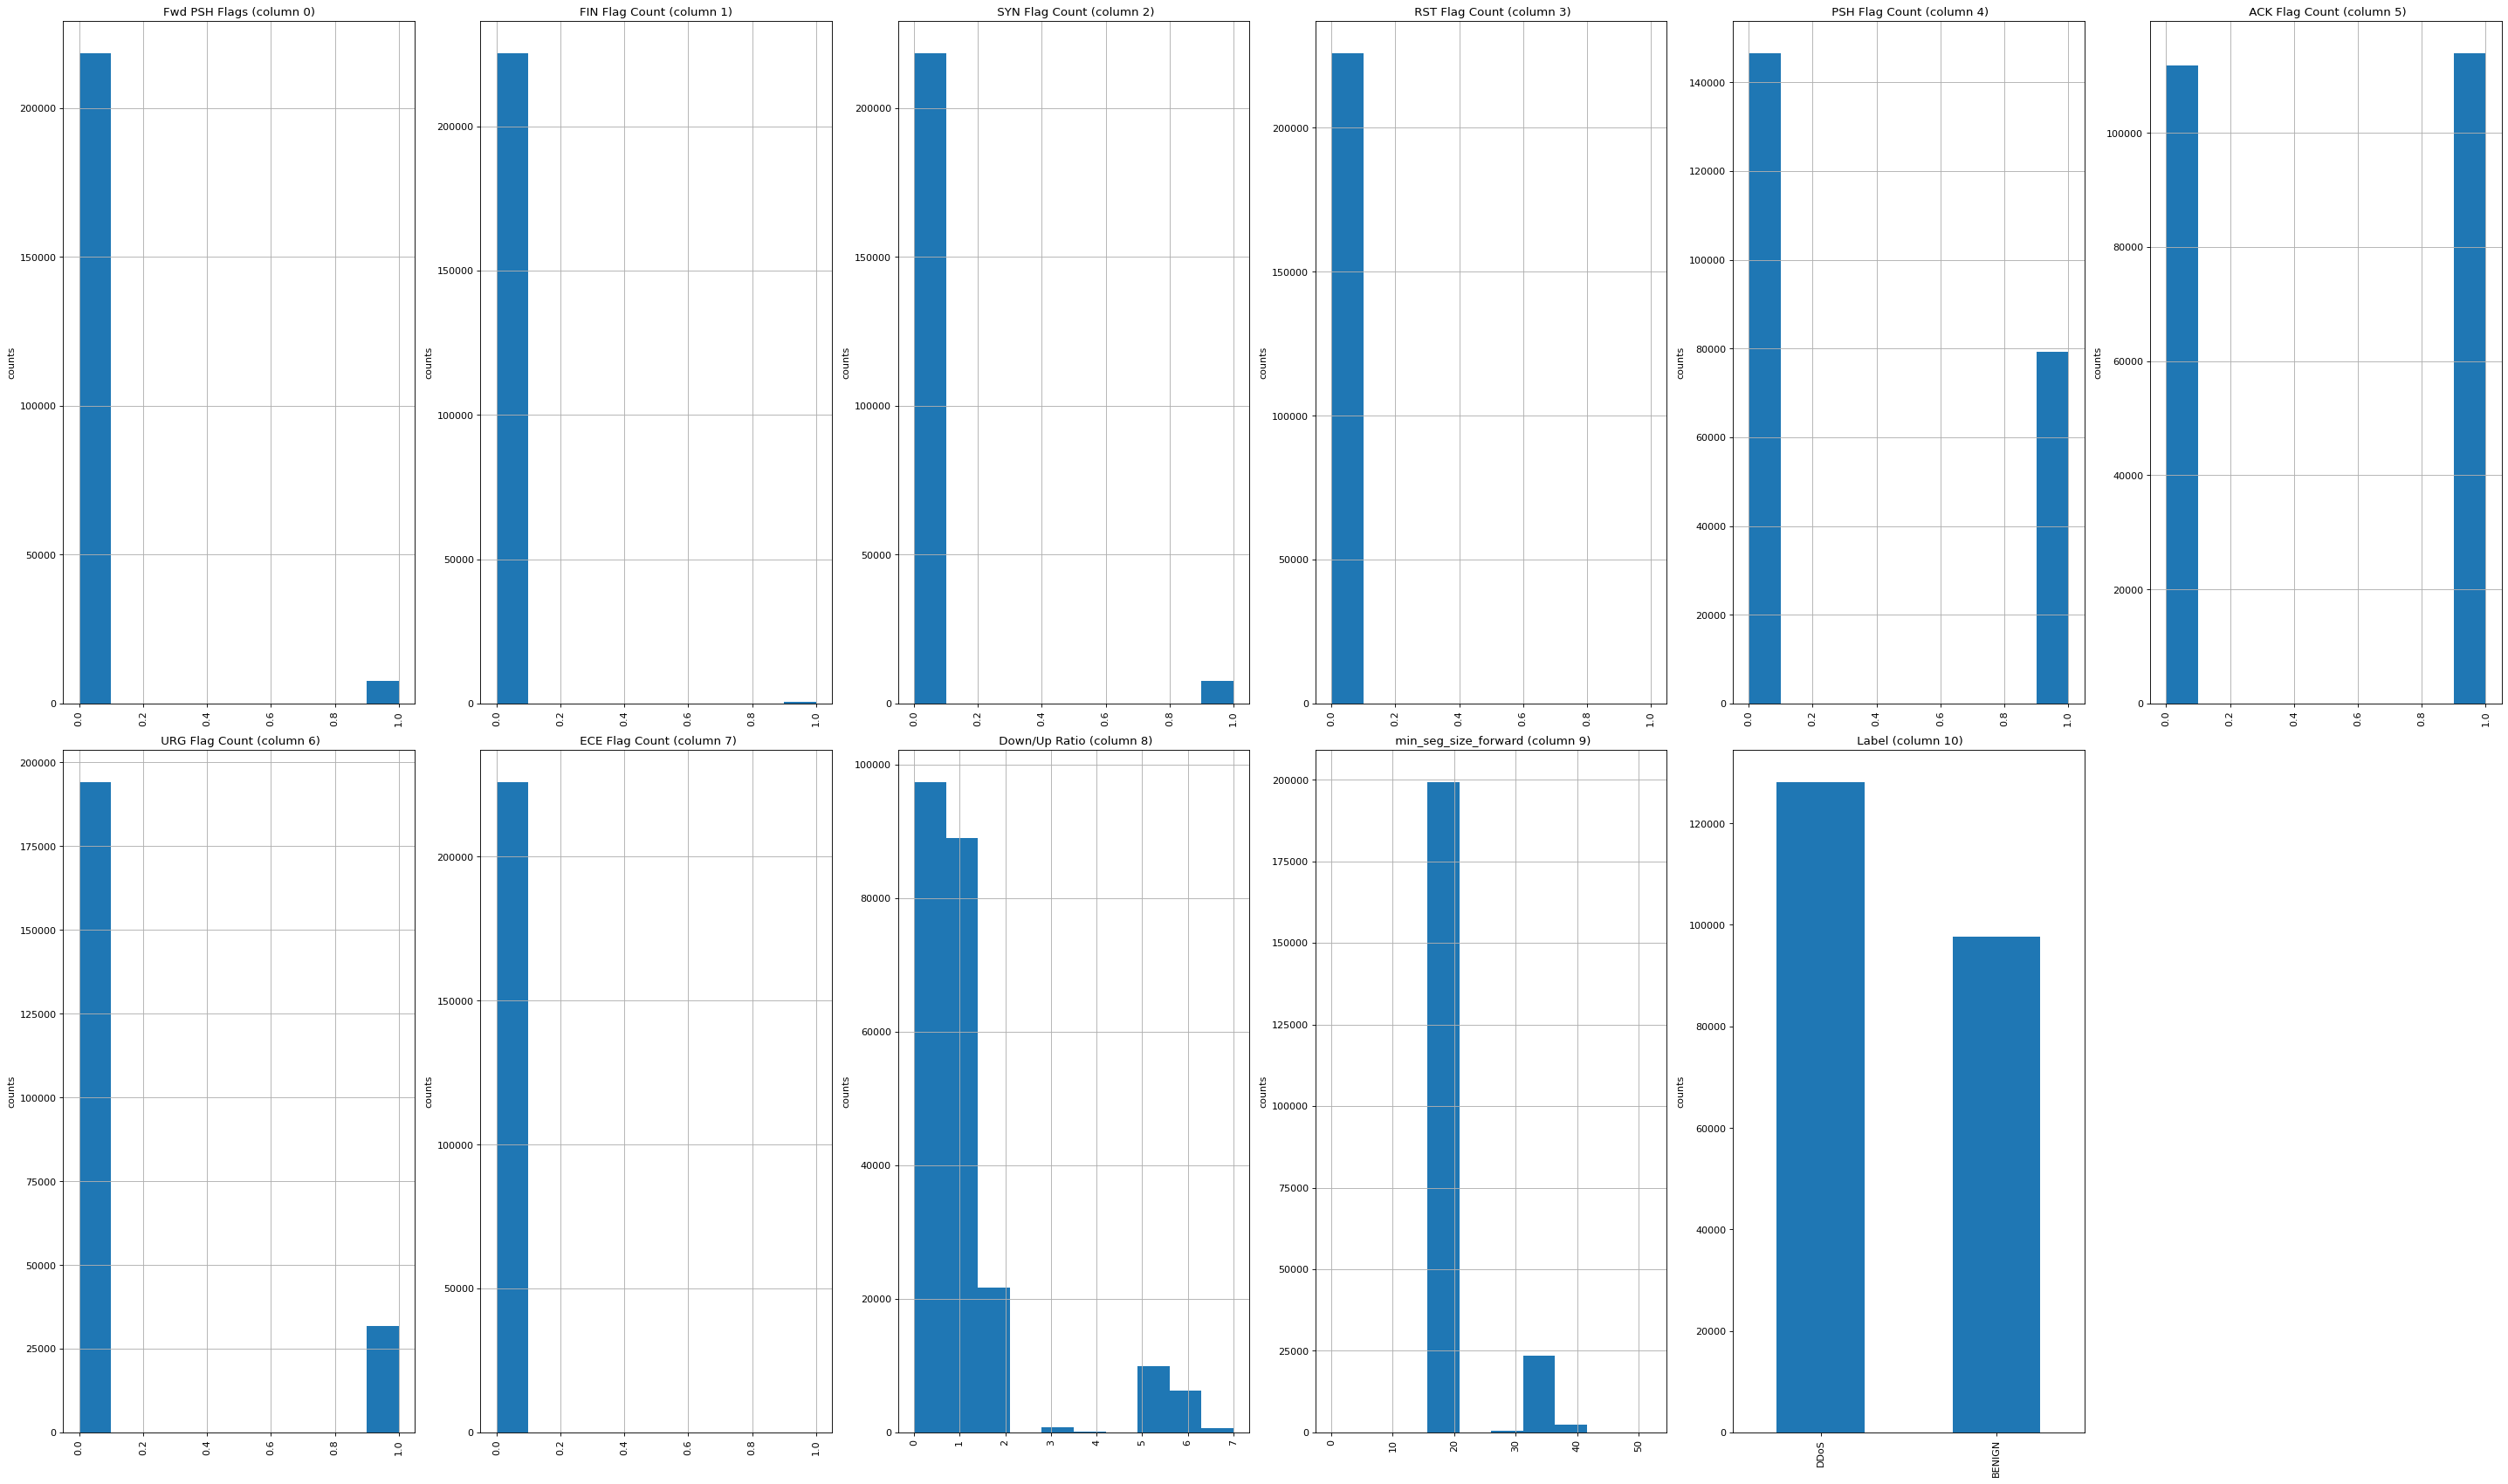

In [9]:
plotPerColumnDistribution(ddos, 12, 6)

Below we have a very nice implementation of one correlation matrix.  
Note the column `Label` is not there. Categorical features (not numerical) are ignored during this process due to their nature of not being continuous. It makes no sense to say if categorical_var1 is increased by one, categorical_var2 also increases by X (X's value depends on the correlation between the 2 variables).  

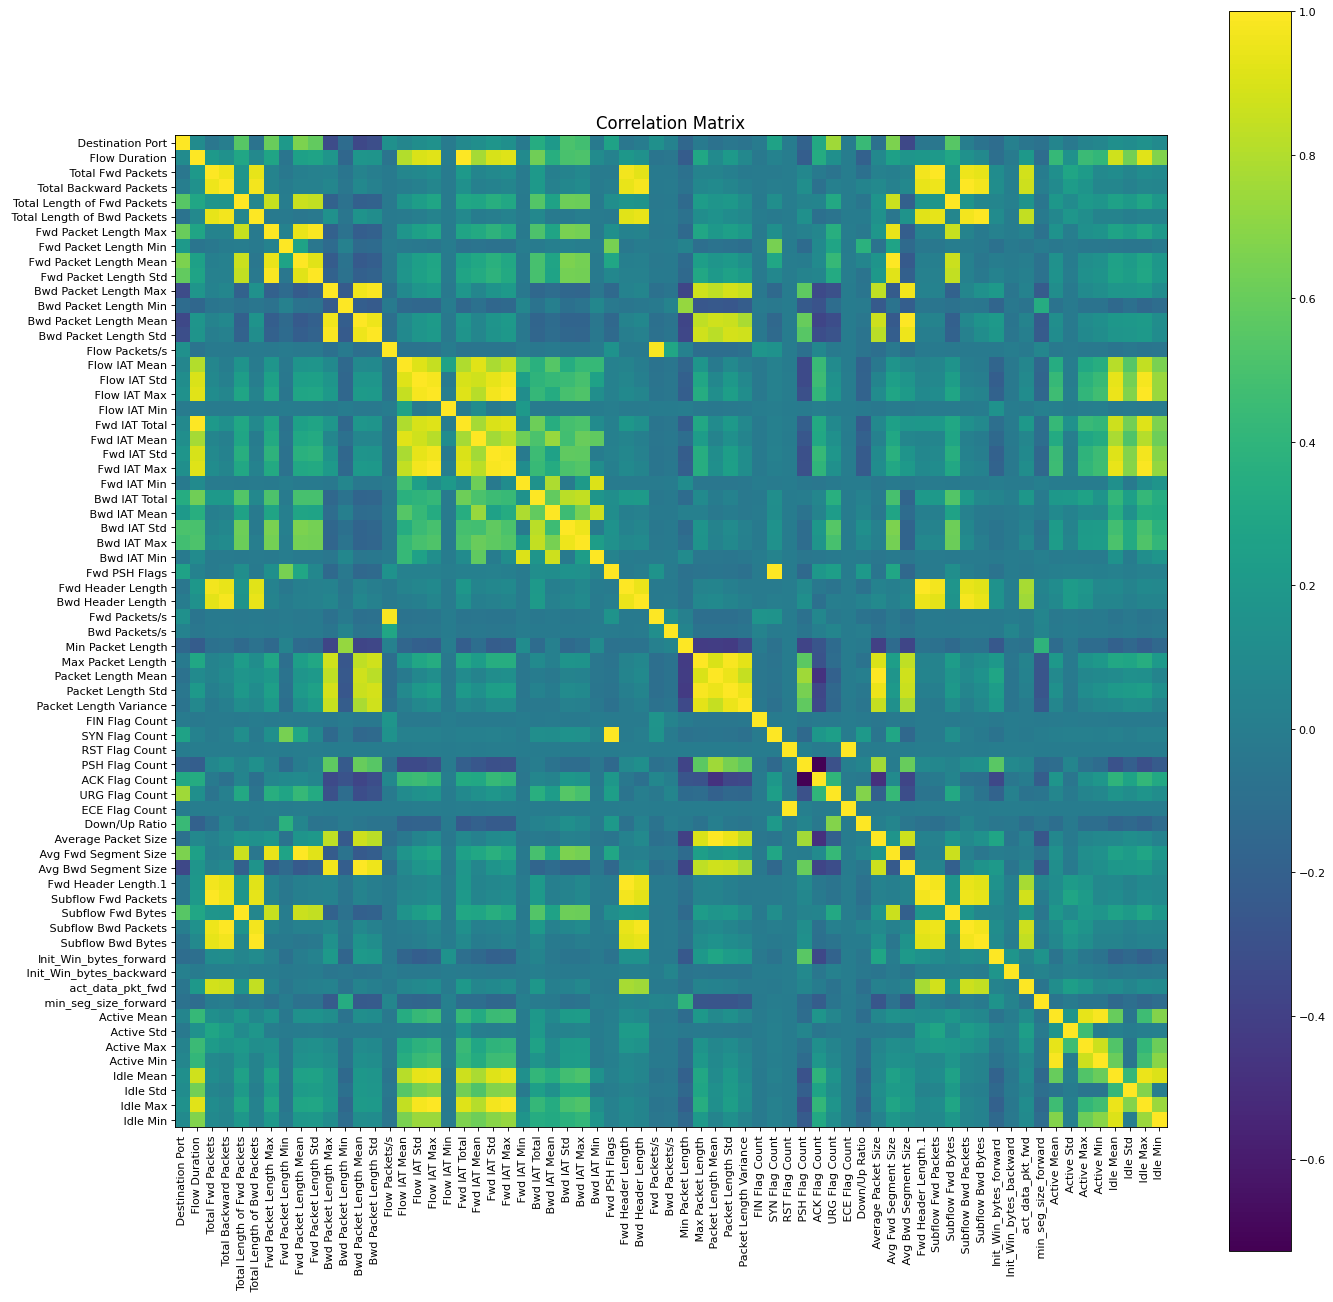

In [10]:
plotCorrelationMatrix(ddos, 20)

Now for the Scatter and density analisys.  
If you are running this notebook be careful, if you are using the whole dataset this can take several minutes. Note we are selecting only the first 10 columns on the function.

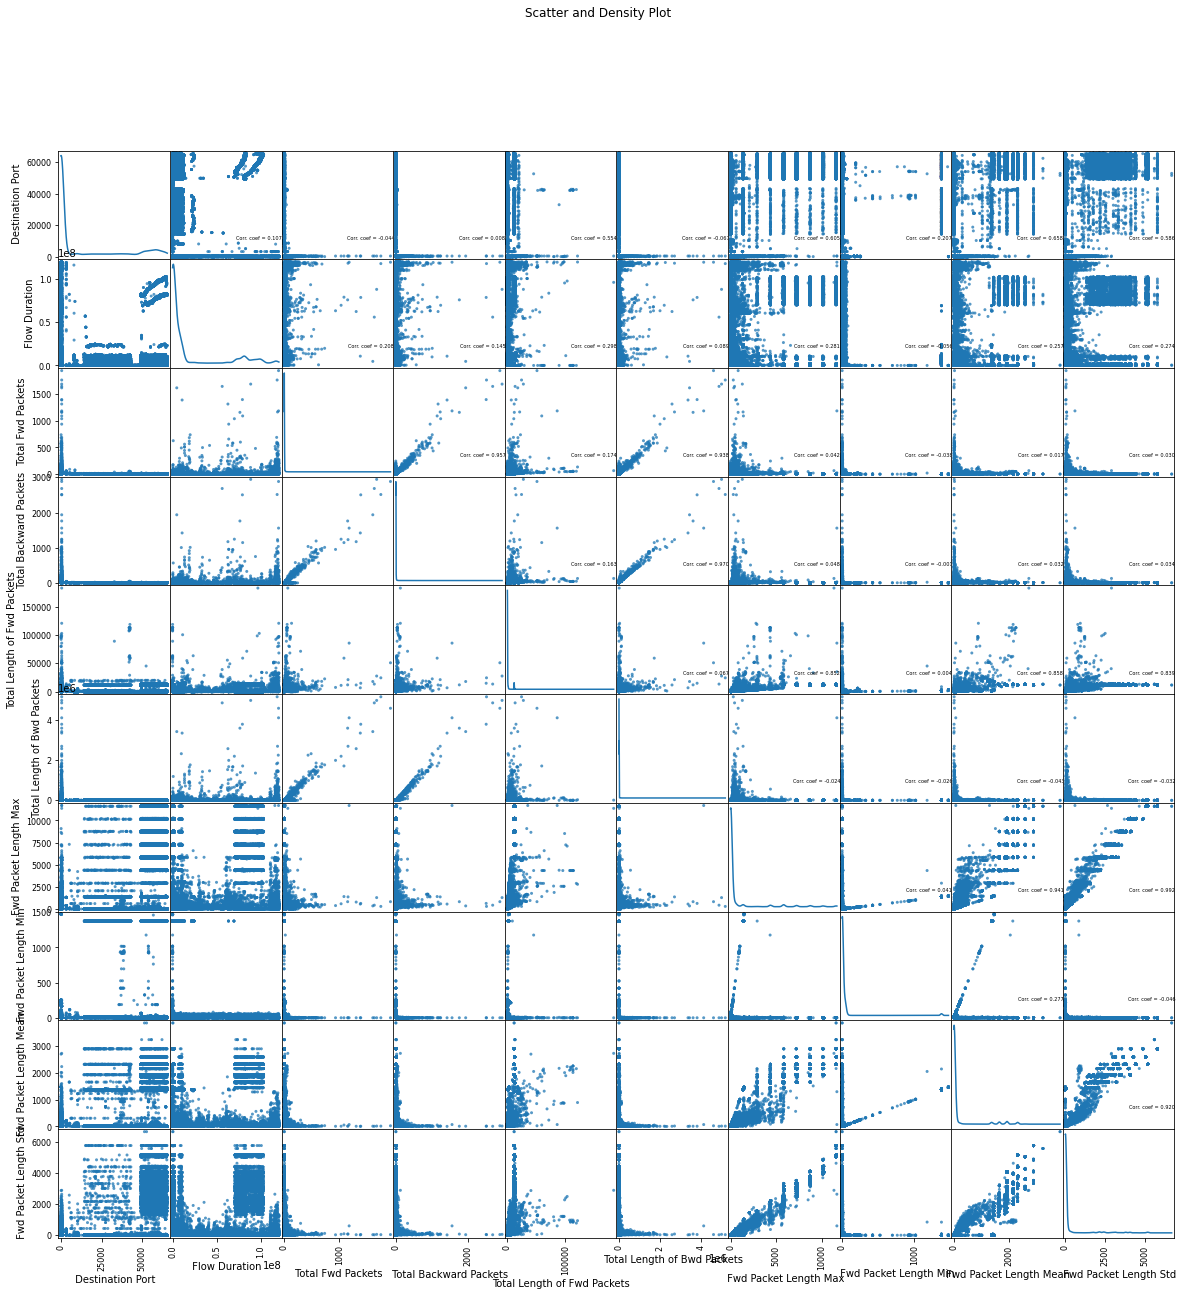

In [11]:
plotScatterMatrix(ddos, 20, 5)

## Research Question

- Can we predict whether the analyzed network traffic is a malignant DDoS attack through a simplistic classification method?

## Methods

### Data cleaning

First, we need to choose do some cleaning on the dataset.

In [12]:
ddos.shape

(225745, 79)

Some column names start with space so to keep consistency we need to make some cleaning on them.

In [13]:
ddos.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [14]:
ddos.columns = ddos.columns.str.replace(' ','') # remove spaces from column names
ddos.columns

Index(['DestinationPort', 'FlowDuration', 'TotalFwdPackets',
       'TotalBackwardPackets', 'TotalLengthofFwdPackets',
       'TotalLengthofBwdPackets', 'FwdPacketLengthMax', 'FwdPacketLengthMin',
       'FwdPacketLengthMean', 'FwdPacketLengthStd', 'BwdPacketLengthMax',
       'BwdPacketLengthMin', 'BwdPacketLengthMean', 'BwdPacketLengthStd',
       'FlowBytes/s', 'FlowPackets/s', 'FlowIATMean', 'FlowIATStd',
       'FlowIATMax', 'FlowIATMin', 'FwdIATTotal', 'FwdIATMean', 'FwdIATStd',
       'FwdIATMax', 'FwdIATMin', 'BwdIATTotal', 'BwdIATMean', 'BwdIATStd',
       'BwdIATMax', 'BwdIATMin', 'FwdPSHFlags', 'BwdPSHFlags', 'FwdURGFlags',
       'BwdURGFlags', 'FwdHeaderLength', 'BwdHeaderLength', 'FwdPackets/s',
       'BwdPackets/s', 'MinPacketLength', 'MaxPacketLength',
       'PacketLengthMean', 'PacketLengthStd', 'PacketLengthVariance',
       'FINFlagCount', 'SYNFlagCount', 'RSTFlagCount', 'PSHFlagCount',
       'ACKFlagCount', 'URGFlagCount', 'CWEFlagCount', 'ECEFlagCount',
       '

To make sure we also check if the dataset have any null value.

In [15]:
ddos.isnull().sum().sum()

4

In [16]:
ddos.shape

(225745, 79)

In [17]:
ddos = ddos.dropna()
ddos.shape

(225741, 79)

### Binarize the Label to 0 or 1 

In [18]:
ddos['BinayLabel'] = (ddos['Label'] == 'DDoS')
print(ddos['BinayLabel'])

0         False
1         False
2         False
3         False
4         False
          ...  
225740    False
225741    False
225742    False
225743    False
225744    False
Name: BinayLabel, Length: 225741, dtype: bool


The target result of `Label` is stored in `y`

In [19]:
y=ddos[['BinayLabel']].copy()
y.head()

,BinayLabel
0,False
1,False
2,False
3,False
4,False


### Column selection

The feature columns were chosen based on the previous exploration of the dataset correlations and some empiric knowledge about network.

In [20]:
features = ['DestinationPort','TotalFwdPackets','TotalBackwardPackets','FwdHeaderLength','BwdHeaderLength',
            'PacketLengthMean','PacketLengthVariance','SYNFlagCount','ACKFlagCount','Down/UpRatio']

In [21]:
x = ddos[features].copy()
x.columns

Index(['DestinationPort', 'TotalFwdPackets', 'TotalBackwardPackets',
       'FwdHeaderLength', 'BwdHeaderLength', 'PacketLengthMean',
       'PacketLengthVariance', 'SYNFlagCount', 'ACKFlagCount', 'Down/UpRatio'],
      dtype='object')

Correlation Matrix for `x`.

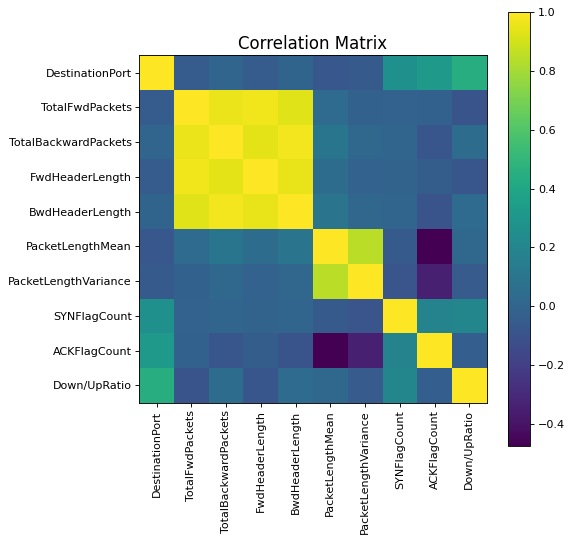

In [22]:
plotCorrelationMatrix(x, 7)

Scatter and density Plot of `x`.

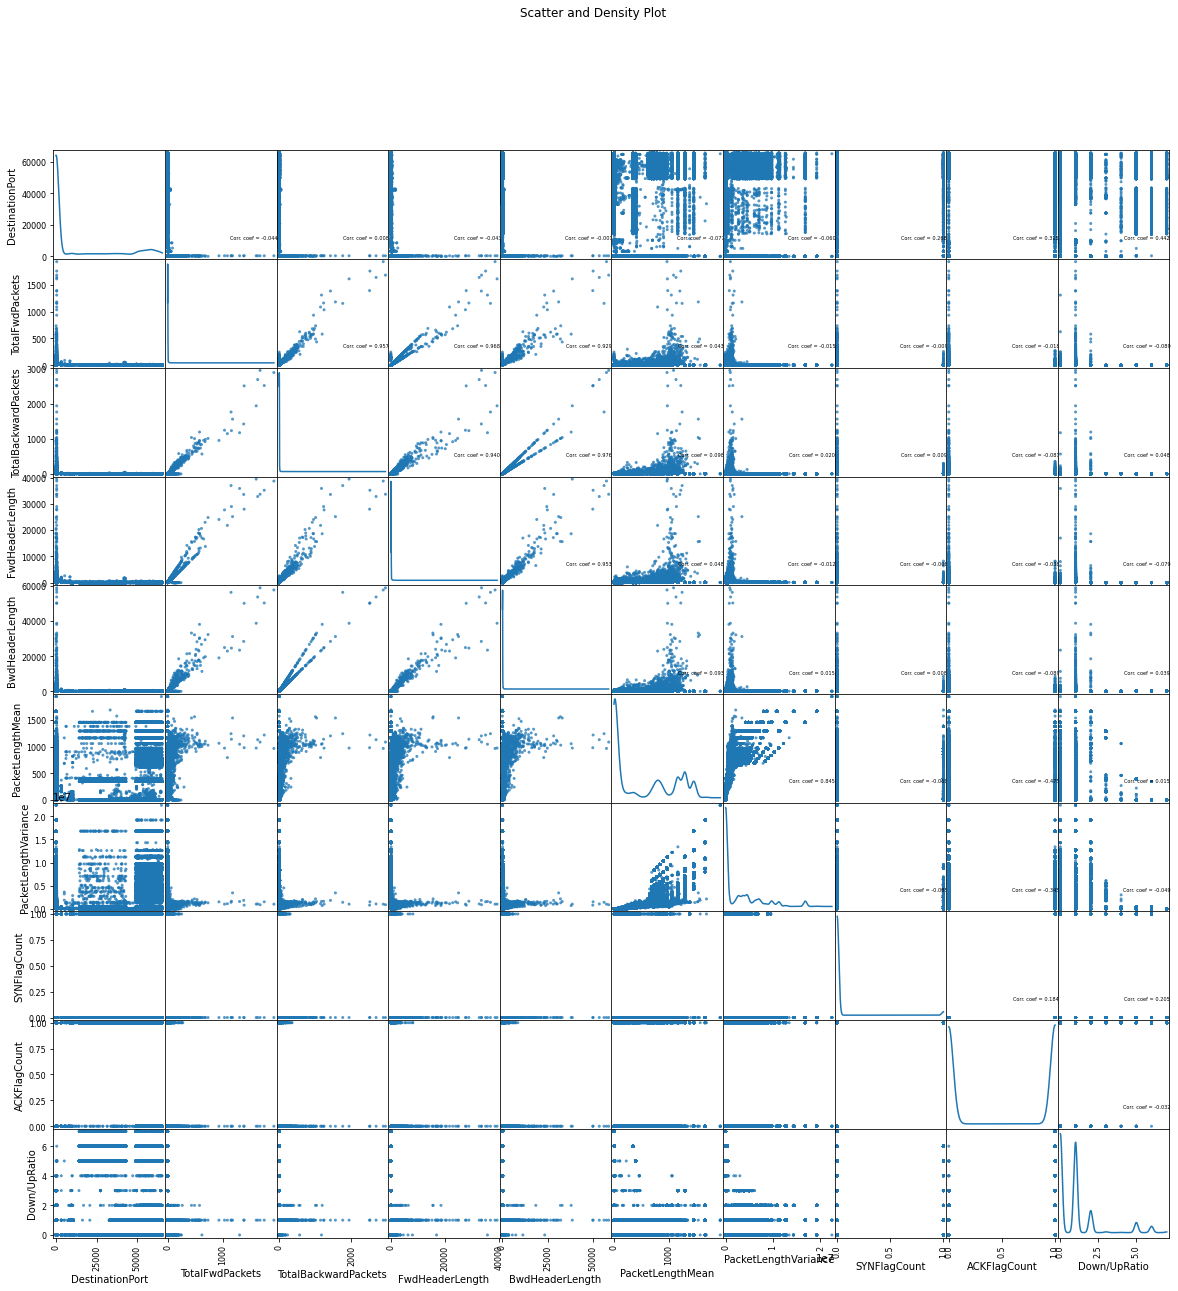

In [23]:
# This can take several minutes
plotScatterMatrix(x, 20, 5)

### Training Phase

In this phase the learning algorithm uses the training data to adjust the model’s parameters to minimize errors.

In [24]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=324)

In [25]:
# type(x_train)
# type(x_test)
# type(y_train)
# type(y_test)
x_train.head()
#y_train.describe()

,DestinationPort,TotalFwdPackets,TotalBackwardPackets,FwdHeaderLength,BwdHeaderLength,PacketLengthMean,PacketLengthVariance,SYNFlagCount,ACKFlagCount,Down/UpRatio
82052,80,7,4,152,92,971.416667,5.447043e+06,0,1,0
58912,80,3,5,72,112,1291.888889,3.923213e+06,0,0,1
117927,80,3,6,72,132,1163.300000,3.625074e+06,0,0,2
169641,80,8,4,172,92,897.615385,1.030000e+07,0,1,0
141781,80,8,4,172,92,897.153846,6.192667e+06,0,1,0


Getting the trained model.

In [26]:
classifier = DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)
classifier.fit(x_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=10, random_state=0)

In [27]:
type(classifier)

sklearn.tree._classes.DecisionTreeClassifier

### Testing phase

In this the trained model is applied to test data.  Test data is separate from the training data, and is previously unseen by the model.  The model is then evaluated on how it performs on the test data.


In [28]:
predictions = classifier.predict(x_test)

In [29]:
predictions[:10]

array([ True, False, False, False,  True,  True,  True, False,  True,
        True])

In [30]:
y_test['BinayLabel'][:10]

154017     True
59280     False
1570      False
219132    False
172751     True
122145     True
132950     True
166177    False
178301     True
44114      True
Name: BinayLabel, dtype: bool

### Measure Accuracy

The goal in building a classifier model is to have the model perform well on training as well as test data.

In [31]:
accuracy_score(y_true = y_test, y_pred = predictions)

0.9947915967514598

### Conclusion

99% of accuracy? Seems something is not right, but I don't know what exactly went wrong. I do trust that my method is correct though.

Some hypotheses to be answered on future works:

- Evaluate if the traffic generated have variation enough.  
Since the traffic analyzed on this dataset was generated by a simulation maybe the requests created are too specific making things easy for the classifier. From Kaggle:
> Generating realistic background traffic was our top priority in building this dataset. We have used our proposed B-Profile system (Sharafaldin, et al. 2016) to profile the abstract behavior of human interactions and generates naturalistic benign background traffic. For this dataset, we built the abstract behavior of 25 users based on the HTTP, HTTPS, FTP, SSH, and email protocols.  

    Maybe the traffic isn't realistic as expected.

- Same for the DDoS attacks created.  
Maybe the attacks are too specific, which is not the real nature of them. This will lead to training the method only to one specific attack type.

- Get some real traffic flow dataset and add DDoS variance.  
There are not many DDoS public datasets available so maybe build one or add new types for the dataset used on this work may be a good option.

- Simply find my error.  
I wasn't able to find if there is something wrong with my training and test methods.